In [1]:
from pathlib import Path

import numpy as np

import src.gdmtools as gdm

from cobaya.run import run
from cobaya.model import get_model
import matplotlib.pyplot as plt


In [2]:
alpha = 0.04

PROJECT_NAME = "gdm_alpha_5w_2c_fixed_ends"
PROJECT_DIR = Path.cwd() / PROJECT_NAME

MODEL_NAME = f"gdm_alpha_{alpha}"

OUTPUT_DIR = PROJECT_DIR / "output/sampler"
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

CLASS_PATH = "/home/mcmeiers/Projects/gdm_cosmology/code/my-class"

In [3]:
gdm_model = gdm.yaml.load(PROJECT_DIR / f"{PROJECT_NAME}+model.yaml")

In [4]:
lcdm_params = {
    "logA": {
        "prior": {"min": 1.61, "max": 3.91},
        "ref": {"dist": "norm", "loc": 3.05, "scale": 0.001},
        "proposal": 0.001,
        "latex": "\\log(10^{10} A_\\mathrm{s})",
        "drop": True,
    },
    "A_s": {
        "value": "lambda logA: 1e-10*np.exp(logA)",
        "min": 1e-10 * np.exp(1.61),
        "max": 1e-10 * np.exp(3.91),
        "latex": "A_\\mathrm{s}",
    },
    "n_s": {
        "prior": {"min": 0.8, "max": 1.2},
        "ref": {"dist": "norm", "loc": 0.965, "scale": 0.004},
        "proposal": 0.002,
        "latex": "n_\\mathrm{s}",
    },
    "theta_s_1e2": {
        "prior": {"min": 0.5, "max": 10},
        "ref": {"dist": "norm", "loc": 1.0416, "scale": 0.0004},
        "proposal": 0.0002,
        "latex": "100\\theta_\\mathrm{s}",
        "drop": True,
    },
    "100*theta_s": {"value": "lambda theta_s_1e2: theta_s_1e2", "derived": False},
    "H0": {"min": 60, "max": 80, "latex": "H_0"},
    "sigma8": {"latex": "\sigma_8"},
    "omega_b": {
        "prior": {"min": 0.005, "max": 0.1},
        "ref": {"dist": "norm", "loc": 0.0224, "scale": 0.0001},
        "proposal": 0.0001,
        "latex": "\\Omega_\\mathrm{b} h^2",
    },
    "omega_cdm": {
        "prior": {"min": 0.001, "max": 0.99},
        "ref": {"dist": "norm", "loc": 0.12, "scale": 0.001},
        "proposal": 0.0005,
        "latex": "\\Omega_\\mathrm{c} h^2",
    },
    "z_reio": {
        "prior": {"min": 6, "max": 9},
        "ref": {"dist": "norm", "loc": 7.5, "scale": 0.75},
        "proposal": 0.4,
    },
    "tau_reio": {"latex": "\\tau_\\mathrm{reio}"},
    "Omega_gdm_max": None,
    "z_gdm_max": None,
}

In [5]:
def gdm_likelihood(_self):
    bg = _self.provider.get_CLASS_background()
    Omega_gdm = bg["(.)rho_gdm"] / bg["H [1/Mpc]"] ** 2
    Omega_gdm_max_idx = np.argmax(Omega_gdm)
    return (
        0,
        {
            "Omega_gdm_max": Omega_gdm[Omega_gdm_max_idx],
            "z_gdm_max": bg["z"][Omega_gdm_max_idx],
        },
    )

In [6]:
cobaya_info = dict(
    theory={
        "classy": {
            "extra_args": {
                **gdm_model.fixed_settings,
                "non_linear": "hmcode",
            },
            # "path": str(CLASS_PATH),
            #'provide': {'get_CLASS_background': None},
        }
    },
    params={**lcdm_params, **gdm_model.params},
    likelihood={
        "planck_2018_lowl.TT": None,
        "planck_2018_lowl.EE": None,
        "planck_2018_highl_plik.TTTEEE_lite": None,
        "planck_2018_lensing.clik": None,
        "gdm": {
            "external": gdm_likelihood,
            "output_params": ["Omega_gdm_max", "z_gdm_max"],
            "requires": {"CLASS_background": None},
        },
    },
    sampler={"mcmc": None},
    output=PROJECT_DIR/"minimizer"/MODEL_NAME,
)

cobaya_info["params"].update({"gdm_alpha": alpha})

In [7]:
cobaya_info

{'theory': {'classy': {'extra_args': {'gdm_log10a_vals': '-14,-4.5,-4.0,-3.5,-3.0,-2.5,0',
    'gdm_interpolation_order': 1,
    'gdm_z_alpha': 3000,
    'non_linear': 'hmcode'}}},
 'params': {'logA': {'prior': {'min': 1.61, 'max': 3.91},
   'ref': {'dist': 'norm', 'loc': 3.05, 'scale': 0.001},
   'proposal': 0.001,
   'latex': '\\log(10^{10} A_\\mathrm{s})',
   'drop': True},
  'A_s': {'value': 'lambda logA: 1e-10*np.exp(logA)',
   'min': 5.002811227833588e-10,
   'max': 4.989895197340787e-09,
   'latex': 'A_\\mathrm{s}'},
  'n_s': {'prior': {'min': 0.8, 'max': 1.2},
   'ref': {'dist': 'norm', 'loc': 0.965, 'scale': 0.004},
   'proposal': 0.002,
   'latex': 'n_\\mathrm{s}'},
  'theta_s_1e2': {'prior': {'min': 0.5, 'max': 10},
   'ref': {'dist': 'norm', 'loc': 1.0416, 'scale': 0.0004},
   'proposal': 0.0002,
   'latex': '100\\theta_\\mathrm{s}',
   'drop': True},
  '100*theta_s': {'value': 'lambda theta_s_1e2: theta_s_1e2',
   'derived': False},
  'H0': {'min': 60, 'max': 80, 'latex': 

In [8]:
#model = get_model(cobaya_info)
updated_info, sampler = run(cobaya_info,debug = True, force = True)

 2022-06-24 01:21:13,631 [output] Output to be read-from/written-into folder '/home/mcmeiers/Projects/gdm_cosmology/workspace/gdm_alpha_5w_2c_fixed_ends/minimizer', with prefix 'gdm_alpha_0.04'
 2022-06-24 01:21:13,631 [output] Found existing info files with the requested output prefix: '/home/mcmeiers/Projects/gdm_cosmology/workspace/gdm_alpha_5w_2c_fixed_ends/minimizer/gdm_alpha_0.04'
 2022-06-24 01:21:13,632 [output] Will delete previous products ('force' was requested).
 2022-06-24 01:21:13,690 [input] Parameter 'A_planck' is multiply defined but consistent.
 2022-06-24 01:21:13,691 [input] Parameter 'A_planck' is multiply defined but consistent.
 2022-06-24 01:21:13,691 [input] Parameter 'A_planck' is multiply defined but consistent.
 2022-06-24 01:21:13,746 [classy] Attempting import of Cobaya-installed version, but defaulting to global import if not found.
 2022-06-24 01:21:13,746 [classy] 'classy' to be imported from (sub)directory /home/mcmeiers/Projects/gdm_cosmology/code/cla

/home/mcmeiers/anaconda3/envs/py39/lib/python3.9/site-packages/cobaya/model.py:81: RuntimeWarning: overflow encountered in double_scalars
  sum(self.loglikes) if self.loglikes is not None else None)


 2022-06-24 01:22:22,891 [planck_2018_lowl.tt] Got parameters {'A_planck': 1.0016111951072344}
 2022-06-24 01:22:22,892 [planck_2018_lowl.tt] Computing new state
 2022-06-24 01:22:22,893 [planck_2018_lowl.tt] Computed log-likelihood = -12.5162
 2022-06-24 01:22:22,894 [planck_2018_lowl.ee] Got parameters {'A_planck': 1.0016111951072344}
 2022-06-24 01:22:22,895 [planck_2018_lowl.ee] Computing new state
 2022-06-24 01:22:22,896 [planck_2018_lowl.ee] Computed log-likelihood = -197.812
 2022-06-24 01:22:22,897 [planck_2018_highl_plik.ttteee_lite] Got parameters {'A_planck': 1.0016111951072344}
 2022-06-24 01:22:22,899 [planck_2018_highl_plik.ttteee_lite] Computing new state
 2022-06-24 01:22:22,900 [planck_2018_highl_plik.ttteee_lite] Computed log-likelihood = -455.866
 2022-06-24 01:22:22,901 [planck_2018_lensing.clik] Got parameters {'A_planck': 1.0016111951072344}
 2022-06-24 01:22:22,902 [planck_2018_lensing.clik] Computing new state
 2022-06-24 01:22:22,904 [planck_2018_lensing.clik]

/home/mcmeiers/anaconda3/envs/py39/lib/python3.9/site-packages/pybobyqa/controller.py:401: RuntimeWarning: overflow encountered in double_scalars
  bdtol = errbig / self.rho


 2022-06-24 01:24:16,247 [planck_2018_lowl.tt] Got parameters {'A_planck': 0.9981575046591672}
 2022-06-24 01:24:16,250 [planck_2018_lowl.tt] Computing new state
 2022-06-24 01:24:16,250 [planck_2018_lowl.tt] Computed log-likelihood = -12.928
 2022-06-24 01:24:16,251 [planck_2018_lowl.ee] Got parameters {'A_planck': 0.9981575046591672}
 2022-06-24 01:24:16,251 [planck_2018_lowl.ee] Computing new state
 2022-06-24 01:24:16,252 [planck_2018_lowl.ee] Computed log-likelihood = -197.826
 2022-06-24 01:24:16,252 [planck_2018_highl_plik.ttteee_lite] Got parameters {'A_planck': 0.9981575046591672}
 2022-06-24 01:24:16,253 [planck_2018_highl_plik.ttteee_lite] Computing new state
 2022-06-24 01:24:16,254 [planck_2018_highl_plik.ttteee_lite] Computed log-likelihood = -352.124
 2022-06-24 01:24:16,254 [planck_2018_lensing.clik] Got parameters {'A_planck': 0.9981575046591672}
 2022-06-24 01:24:16,254 [planck_2018_lensing.clik] Computing new state
 2022-06-24 01:24:16,257 [planck_2018_lensing.clik] 

In [11]:
{sampler.products()['minimum'][k] for k in sampler.model.parameterization.input_params()

  weight minuslogpost      logA       n_s theta_s_1e2   omega_b omega_cdm  \
0    1.0   560.424803  3.049348  0.966777    1.040936  0.022517  0.118961   

     z_reio       w_0       w_1  ...    z_gdm_max   chi2__CMB minuslogprior  \
0  7.279499 -0.660637  0.165566  ...  2786.073249  1121.71613     -0.433262   

  minuslogprior__0        chi2 chi2__planck_2018_lowl.TT  \
0        -0.433262  1121.71613                 25.843027   

  chi2__planck_2018_lowl.EE chi2__planck_2018_highl_plik.TTTEEE_lite  \
0                395.635958                               685.424938   

  chi2__planck_2018_lensing.clik chi2__gdm  
0                      14.812207      -0.0  

[1 rows x 31 columns]

In [9]:
with open("/home/mcmeiers/Projects/gdm_cosmology/workspace/gdm_alpha_5w_2c_fixed_ends/minimizer/gdm_alpha_0.05.minimum.txt", "r") as f:
    lines = f.readlines()
    param_names = lines[0].split()[1:]
    param_names = lines[0].split()[1:]
    param_vals = map(float,lines[1].split())
    params = dict(zip(param_names,param_vals))

best_fit ={'gdm_alpha':0.05}
for k in model.parameterization.sampled_params():
    try:
        best_fit[k] = params[k]
    except:
        pass


plk18={"logA":3.00448,
 "n_s":0.96605,
 "theta_s_1e2":1.041783,
 "omega_b": 0.02238280,
 "omega_cdm": 0.1201075,
 "z_reio":7.6711,
 "gdm_alpha": 1e-32,
 'w_0': 0.0,
 'w_1': -0.0,
 'w_2': -0.0,
 'w_3': 0.0,
 'w_4': 0.0,
 'gdm_c_eff2': 0.0,
 'gdm_c_vis2': 0.0,
 'A_planck': 0.99861131
}

NameError: name 'model' is not defined

In [21]:
import pandas as pd
data = {
    k: sampler.products()["minimum"][k]
    for k in sampler.model.parameterization.sampled_params().keys()
}
df = pd.DataFrame(data, index=[0])

# append data frame to CSV file
df.to_csv("test.csv", mode="a", index=False,header=False)


[parameterization] *ERROR* Cannot change value of constant parameter: gdm_alpha = 0.05 (new) vs 0.04 (old).


LoggedError: Cannot change value of constant parameter: gdm_alpha = 0.05 (new) vs 0.04 (old).

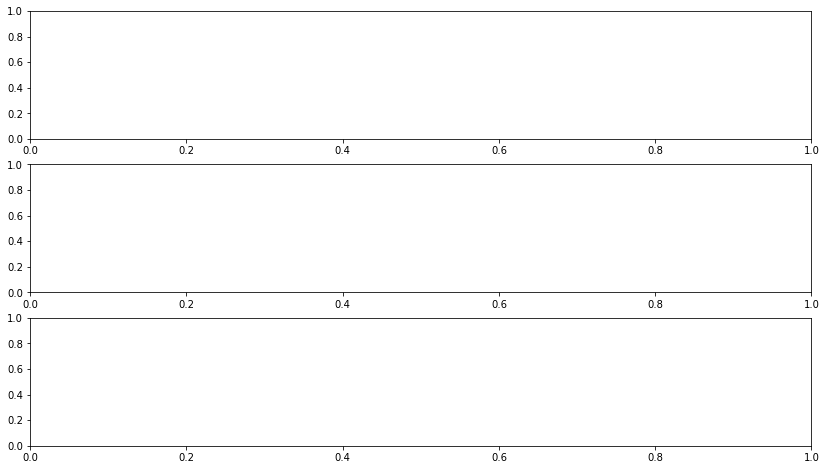

In [ ]:
param_sets = [(r"$\alpha=0.05$",best_fit),(r"plk18",plk18)]
modes = ['tt','te','ee']



f, axs = plt.subplots(3, figsize=(14, 8))
for label,ps in param_sets:
    model.logposterior(ps)  # to force computation of theory
    Cls = model.provider.get_Cl(ell_factor=True)
    for mode, ax in zip(modes,axs):
        ax.plot(Cls["ell"][2:], Cls[mode][2:], label=label)
        ax.set_ylabel(r"$\ell(\ell+1)/(2\pi)\,C^"+str(mode)+"_\ell\;(\mu \mathrm{K}^2)$")
    
for ax in axs:
    ax.set_xlabel(r"$\ell$")
    ax.legend()
plt.savefig("alphabf.png")



In [ ]:
Cls = {}
for name,ps in param_sets:
    model.logposterior(ps)  # to force computation of theory
    Cls[name]=model.provider.get_Cl(ell_factor=True)

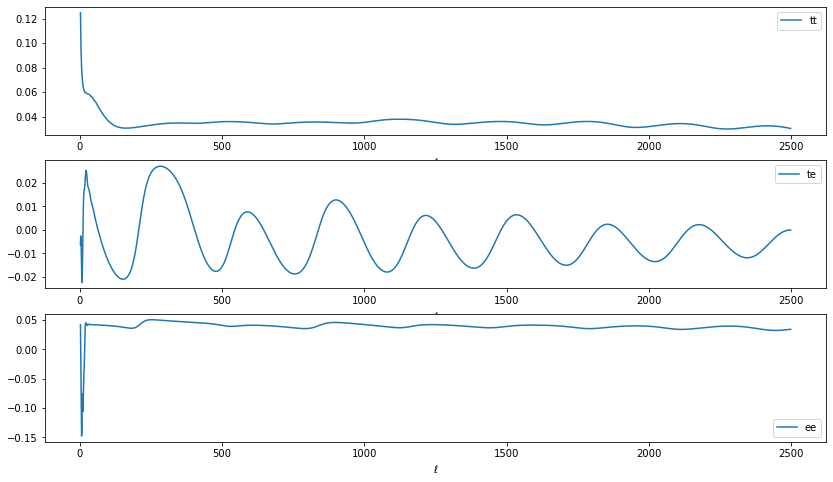

In [ ]:





f, axs = plt.subplots(3, figsize=(14, 8))

axs[0].plot(Cls[r"$\alpha=0.05$"]["ell"][2:2500],(Cls[r"$\alpha=0.05$"]['tt'][2:2500]-Cls[r"plk18"]['tt'][2:2500])/(Cls[r"plk18"]['tt'][2:2500]), label='tt')
axs[1].plot(Cls[r"$\alpha=0.05$"]["ell"][2:2500],(Cls[r"$\alpha=0.05$"]['te'][2:2500]-Cls[r"plk18"]['te'][2:2500])/(Cls[r"plk18"]['tt'][2:2500]*Cls[r"plk18"]['ee'][2:2500])**(1/2.), label='te')
axs[2].plot(Cls[r"$\alpha=0.05$"]["ell"][2:2500],(Cls[r"$\alpha=0.05$"]['ee'][2:2500]-Cls[r"plk18"]['ee'][2:2500])/(Cls[r"plk18"]['ee'][2:2500]), label='ee')
  
for ax in axs:
    ax.set_xlabel(r"$\ell$")
    ax.legend()
plt.savefig("alphabf.png")

[matplotlib.legend] *WARNING* No handles with labels found to put in legend.


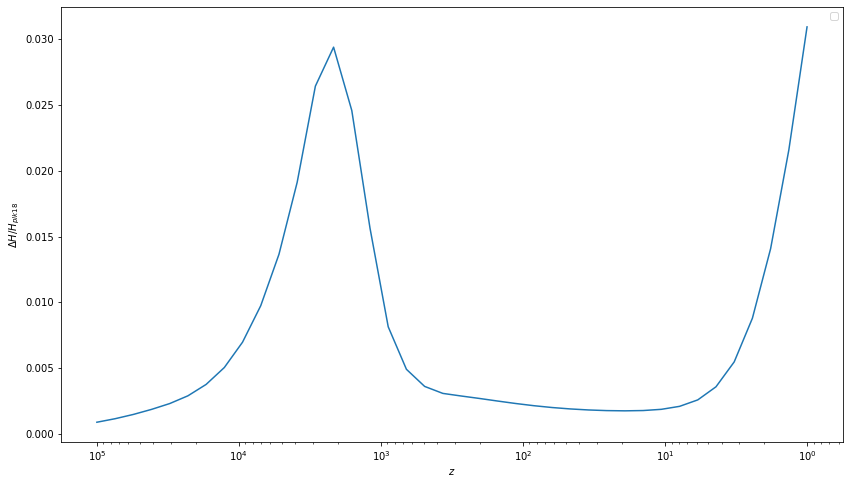

In [ ]:
H_of_param_set = {}
redshifts = np.logspace(0, 5, 40)
model.add_requirements({"Hubble": {"z": redshifts}})
for name,ps in param_sets:
    model.logposterior(ps)  # to force computation of theory
    H_of_param_set[name]=model.provider.get_Hubble(redshifts)


f, ax = plt.subplots(figsize=(14, 8))
ax.semilogx(redshifts, (H_of_param_set[r"$\alpha=0.05$"]-H_of_param_set[r"plk18"])/(H_of_param_set[r"plk18"]),)
ax.invert_xaxis()

ax.set_ylabel(r"$\Delta H/H_{plk18}$")
ax.set_xlabel(r"$z$")
ax.legend()




In [ ]:
plk18={"logA":3.00448,
 "n_s":0.96605,
 "100*theta_s":1.041783,
 "omega_b": 0.02238280,
 "omega_cdm": 0.1201075,
 "z_reio":7.6711,
 "gdm_alpha": 0.0
}

In [ ]:
best_fit

{'gdm_alpha': 0.05,
 'logA': 3.0525241,
 'n_s': 0.97009128,
 'theta_s_1e2': 1.0416625,
 'omega_b': 0.022746018,
 'omega_cdm': 0.12021497,
 'z_reio': 7.4636365,
 'w_0': 0.072852437,
 'w_1': -0.13727259,
 'w_2': -0.23230183,
 'w_3': 1.0,
 'w_4': 0.17725984,
 'gdm_c_eff2': 0.080912042,
 'gdm_c_vis2': 0.18811092,
 'A_planck': 0.99861131}

In [ ]:
model = sampler.model
formodel.parameterization.input_params()

{'logA': 3.0553816617638136,
 'A_s': 2.1229286387806547e-09,
 'n_s': 0.974290378522768,
 'theta_s_1e2': 1.0411618846984287,
 '100*theta_s': 1.0411618846984287,
 'omega_b': 0.02260213114568783,
 'omega_cdm': 0.1240141722665251,
 'z_reio': 7.890217585622125,
 'gdm_alpha': 0.04,
 'w_0': 0.5971825128732019,
 'w_1': -0.5676498601662903,
 'w_2': 0.14542643157192375,
 'w_3': 1.0,
 'w_4': 1.0,
 'w_fixed0': -1.0,
 'w_fixed1': 1.0,
 'gdm_w_vals': '-1.0,0.5971825128732019,-0.5676498601662903,0.14542643157192375,1.0,1.0,1.0',
 'gdm_c_eff2': 0.5687720325681733,
 'gdm_c_vis2': 0.002698076452268272,
 'A_planck': 1.0013379867353003}

In [ ]:
'gdm_c_eff2' in sampler.products()['minimum']

False

In [ ]:
best_fit ={}
for k in model.parameterization.sampled_params():
    best_fit[k] = sampler.products()['minimum'][k]


logposterior = model.logposterior(best_fit, as_dict=True)

 2022-06-22 09:50:08,783 [model] Posterior to be computed for parameters {'logA': 3.0553816617638136, 'n_s': 0.974290378522768, 'theta_s_1e2': 1.0411618846984287, 'omega_b': 0.02260213114568783, 'omega_cdm': 0.1240141722665251, 'z_reio': 7.890217585622125, 'w_0': 0.5971825128732019, 'w_1': -0.5676498601662903, 'w_2': 0.14542643157192375, 'w_3': 1.0, 'w_4': 1.0, 'gdm_c_eff2': 0.5687720325681733, 'gdm_c_vis2': 0.002698076452268272, 'A_planck': 1.0013379867353003}
 2022-06-22 09:50:08,784 [prior] Evaluating prior at array([ 3.05538166e+00,  9.74290379e-01,  1.04116188e+00,  2.26021311e-02,
        1.24014172e-01,  7.89021759e+00,  5.97182513e-01, -5.67649860e-01,
        1.45426432e-01,  1.00000000e+00,  1.00000000e+00,  5.68772033e-01,
        2.69807645e-03,  1.00133799e+00])
 2022-06-22 09:50:08,784 [prior] Got logpriors = 0.5619902872018905
 2022-06-22 09:50:08,784 [model] Got input parameters: {'logA': 3.0553816617638136, 'A_s': 2.1229286387806547e-09, 'n_s': 0.974290378522768, 'thet

In [ ]:
Cls_bf = model.provider.get_Cl(ell_factor=True)



NameError: name 'model' is not defined

{'tt': array([0.00000000e+00, 0.00000000e+00, 1.02344671e+03, ...,
        6.30938088e-01, 6.30616065e-01, 6.30300623e-01]),
 'ee': array([0.        , 0.        , 0.03126946, ..., 0.01509249, 0.01506597,
        0.0150395 ]),
 'te': array([ 0.        ,  0.        ,  2.53001057, ..., -0.019689  ,
        -0.01965134, -0.0196137 ]),
 'bb': array([0.00000000e+00, 0.00000000e+00, 1.82991421e-06, ...,
        3.03239887e-03, 3.02956329e-03, 3.02673088e-03]),
 'pp': array([0.00000000e+00, 0.00000000e+00, 4.75560811e-08, ...,
        1.90811412e-10, 1.90669130e-10, 1.90526947e-10]),
 'tp': array([0.00000000e+00, 0.00000000e+00, 3.47773602e+03, ...,
        1.23665452e-05, 1.23560289e-05, 1.23456602e-05]),
 'ell': array([   0,    1,    2, ..., 4998, 4999, 5000])}

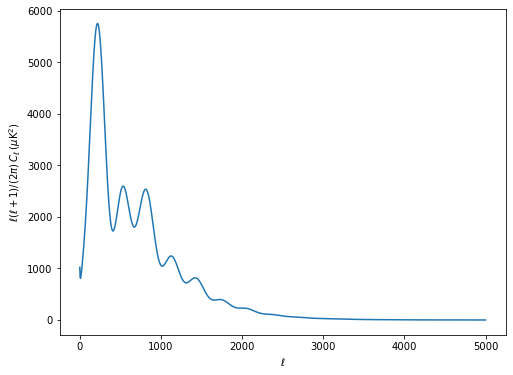

In [ ]:

plt.figure(figsize=(8, 6))
plt.plot(Cls["ell"][2:], Cls["tt"][2:])
plt.ylabel(r"$\ell(\ell+1)/(2\pi)\,C_\ell\;(\mu \mathrm{K}^2)$")
plt.xlabel(r"$\ell$")
plt.savefig("cltt.png")
plt.show()

In [ ]:
best_fit

{'logA': 3.0553816617638136,
 'n_s': 0.974290378522768,
 'theta_s_1e2': 1.0411618846984287,
 'omega_b': 0.02260213114568783,
 'omega_cdm': 0.1240141722665251,
 'z_reio': 7.890217585622125,
 'w_0': 0.5971825128732019,
 'w_1': -0.5676498601662903,
 'w_2': 0.14542643157192375,
 'w_3': 1.0,
 'w_4': 1.0,
 'gdm_c_eff2': 0.5687720325681733,
 'gdm_c_vis2': 0.002698076452268272,
 'A_planck': 1.0013379867353003}

In [ ]:
r"$\ell(\ell+1)/(2\pi)\,C^{mode}_\ell\;(\mu \mathrm{K}^2)$"

KeyError: 'K'

In [ ]:
from classy import Class



In [ ]:
cosmo = Class()
cosmo.set({'A_s': 2.109843654335196e-09, 'n_s': 0.9682256778657358, '100*theta_s': 1.0416570151018314, 'omega_b': 0.022344649211073528, 'omega_cdm': 0.12026790581268844, 'z_reio': 6.566572924175148, 'gdm_alpha': 0.05, 'gdm_w_vals': '-1.0,0.4160833037723448,0.7642675107047947,0.5682936521397142,0.36458195536282445,0.23224825743549893,1.0', 'gdm_c_eff2': 0.4883049724964518, 'gdm_c_vis2': 0.40073061104874297, 'gdm_log10a_vals': '-14,-4.5,-4.0,-3.5,-3.0,-2.5,0', 'gdm_interpolation_order': 1, 'gdm_z_alpha': 3000, 'non_linear': 'hmcode', 'output': 'tCl lCl mPk pCl', 'l_max_scalars': 2508, 'lensing': 'yes', 'P_k_max_1/Mpc': 1})
cosmo.compute()

In [ ]:
cosmo.compute()

CosmoSevereError: 

Error in Class: input_read_from_file(L:417) :error in input_shooting(pfc,ppr,pba,pth,ppt,ptr,ppm,phr,pfo,ple,psd,pop, input_verbose, &has_shooting, errmsg);
=>input_shooting(L:724) :error in input_read_parameters(&(fzw.fc),ppr,pba,pth,ppt,ptr,ppm,phr,pfo,ple,psd,pop, errmsg);
=>input_read_parameters(L:1629) :error in input_read_parameters_species(pfc,ppr,pba,pth,ppt, input_verbose, errmsg);
=>input_read_parameters_species(L:3357) :condition (w_ext<-1 || w_ext >1) is true; |w|>1 in interval indexed 0, check gdm_w_vals

In [ ]:
cobaya_info

{'theory': {'classy': {'extra_args': {'gdm_log10a_vals': '-14,-4.5,-4.0,-3.5,-3.0,-2.5,0',
    'gdm_interpolation_order': 1,
    'gdm_z_alpha': 3000,
    'non_linear': 'hmcode'}}},
 'params': {'logA': {'prior': {'min': 1.61, 'max': 3.91},
   'ref': {'dist': 'norm', 'loc': 3.05, 'scale': 0.001},
   'proposal': 0.001,
   'latex': '\\log(10^{10} A_\\mathrm{s})',
   'drop': True},
  'A_s': {'value': 'lambda logA: 1e-10*np.exp(logA)',
   'min': 5.002811227833588e-10,
   'max': 4.989895197340787e-09,
   'latex': 'A_\\mathrm{s}'},
  'n_s': {'prior': {'min': 0.8, 'max': 1.2},
   'ref': {'dist': 'norm', 'loc': 0.965, 'scale': 0.004},
   'proposal': 0.002,
   'latex': 'n_\\mathrm{s}'},
  'theta_s_1e2': {'prior': {'min': 0.5, 'max': 10},
   'ref': {'dist': 'norm', 'loc': 1.0416, 'scale': 0.0004},
   'proposal': 0.0002,
   'latex': '100\\theta_\\mathrm{s}',
   'drop': True},
  '100*theta_s': {'value': 'lambda theta_s_1e2: theta_s_1e2',
   'derived': False},
  'H0': {'min': 60, 'max': 80, 'latex': 